<a href="https://colab.research.google.com/github/Natasha617/DZ_NLP/blob/DZ_4/DZ_4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №4 Шафорост НВ

Исходный набор данных - Fake and real news dataset

Реализовать классификацию двумя моделями: CNN, LSTM - 6 баллов = 3 + 3

Сравнить качество обученных моделей 1 балл

Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - 2 балла

Соблюден code style на уровне pep8 и On writing clean Jupyter notebooks - 1 балл

## **Библиотеки**

In [18]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.layers import LSTM, Bidirectional, Input, MaxPooling1D
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Random_state = 147

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Данные**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/магистратура/NLP/data4/Fake.csv" /content/data_fake.csv
!cp "/content/drive/MyDrive/магистратура/NLP/data4/True.csv" /content/data_true.csv

Mounted at /content/drive


In [8]:
data1 = pd.read_csv("data_fake.csv")
data2= pd.read_csv("data_true.csv")
data1['target']=0
data2['target']=1
data = pd.concat([data1,data2])

In [9]:
print(data1.shape)
print(data2.shape)
print(data.shape)

(23481, 5)
(21417, 5)
(44898, 5)


In [10]:
data.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


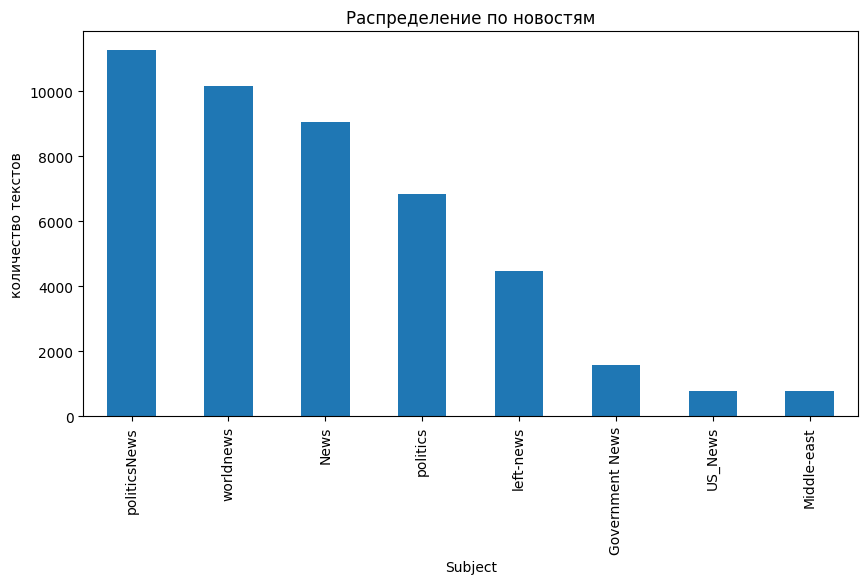

In [12]:
data['subject'].value_counts().plot(kind='bar', figsize=(10,5), title='Распределение по новостям')
plt.xlabel('Subject')
plt.ylabel('количество текстов')
plt.show()

# Очистка текста

In [13]:
from nltk.stem import WordNetLemmatizer
new_df=[]
for d in data['text']:
    new_df.append(d.split(" "))

unique_stops = set(stopwords.words('english'))

# создаём пустой список без стоп-слов
no_stops = []
for li in new_df:
    no_stop = []
    for word in li:
      word = word.lower()
      if word not in unique_stops and word.isalpha():
        no_stop.append(word)
    no_stops.append(no_stop)

lemmatizer = WordNetLemmatizer()

# и пустой список для слов после лемматизации
lemmatized = []
for li in no_stops:
    lemma = []
    for word in li:
      word = lemmatizer.lemmatize(word)
      lemma.append(word)
    lemmatized.append(lemma)

data['clean_text'] = lemmatized

data

,title,text,subject,date,target,clean_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,"[donald, trump, wish, american, happy, new, ye..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,"[house, intelligence, committee, chairman, dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,"[revealed, former, milwaukee, sheriff, david, ..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,"[christmas, donald, trump, announced, would, b..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,"[pope, francis, used, annual, christmas, day, ..."
...,...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1,"[brussels, nato, ally, tuesday, welcomed, pres..."
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1,"[london, provider, regulatory, business, said,..."
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1,"[minsk, shadow, disused, factory, street, line..."
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1,"[moscow, vatican, secretary, state, cardinal, ..."


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['target'], random_state = Random_state)

## **Векторизация**

In [16]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# **LSTM**

In [17]:
max_length = 200  # Максимальная длина последовательности

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
X_test_pad

array([[4986, 1400,   15, ...,    0,    0,    0],
       [  91,  253, 5610, ...,   38,    5,   75],
       [  19,  897,   19, ...,    0,    0,    0],
       ...,
       [6675,  176, 1577, ...,    0,    0,    0],
       [  40,    4,   11, ...,    0,    0,    0],
       [ 826,   24,  117, ...,  294, 2851,  104]], dtype=int32)

In [19]:
np.shape(X_train_pad[0])

(200,)

In [20]:
keras.utils.set_random_seed(147)
tf.random.set_seed(147)


inputs = keras.Input(shape=[200])
x = keras.layers.Embedding(input_dim=10000, output_dim=100)(inputs)
x = keras.layers.LSTM(100)(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)

model_lstm = keras.Model(inputs, outputs)


In [21]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model_lstm.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=3, batch_size=64)

Epoch 1/3
527/527 [==============================] - 73s 126ms/step - loss: 0.4028 - accuracy: 0.8359 - val_loss: 0.2758 - val_accuracy: 0.9110
Epoch 2/3
527/527 [==============================] - 26s 50ms/step - loss: 0.2635 - accuracy: 0.9143 - val_loss: 0.2077 - val_accuracy: 0.9395
Epoch 3/3
527/527 [==============================] - 17s 32ms/step - loss: 0.2091 - accuracy: 0.9404 - val_loss: 0.2244 - val_accuracy: 0.9327


# **CNN**

In [23]:
model_CNN = Sequential()
model_CNN.add(Embedding(input_dim=10000, output_dim=100, input_length=max_length))
model_CNN.add(Conv1D(64, 3, activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=147)))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=147)))
model_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_CNN.summary

In [25]:
model_CNN.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=3, batch_size=64)

Epoch 1/3
527/527 [==============================] - 43s 69ms/step - loss: 0.1947 - accuracy: 0.9349 - val_loss: 0.0734 - val_accuracy: 0.9752
Epoch 2/3
527/527 [==============================] - 16s 30ms/step - loss: 0.0398 - accuracy: 0.9883 - val_loss: 0.0536 - val_accuracy: 0.9815
Epoch 3/3
527/527 [==============================] - 9s 18ms/step - loss: 0.0108 - accuracy: 0.9981 - val_loss: 0.0511 - val_accuracy: 0.9821


# **Вывод**

**Модель CNN показала результат лучше, чем LSTM**